# Classification - penguins



In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from functions import model_perform


In [2]:
# Load the data
df=pd.read_csv('penguins.csv')
df

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


## Description of the dataset

The penguin's dataset contains measurements of three different species of penguins: Adelie, Chinstrap, and Gentoo. These measurements were collected from the Palmer Archipelago in Antarctica. The dataset includes the following features:

- Culmen Length (mm): The length of the penguin's culmen.
- Culmen Depth (mm): The depth of the penguin's culmen.
- Flipper Length (mm): The length of the penguin's flipper.
- Body Mass (g): The body mass of the penguin.

The target vector:
- Species: The species of the penguin (Adelie, Chinstrap, Gentoo).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


### Missingness

Verifying the number of samples and checking the completeness of the data.

In [4]:
display(df.isnull().sum())
df.dropna(inplace=True)
df.info()
df.shape


CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        342 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.0 KB


(342, 5)

Two rows were removed from the dataset due to entirely incomplete information about the penguins' features. The remaining dataset consists of 342 samples, covering 4 features and the target variable.

## Exploratory Data Analysis (EDA)

Descriptive statistics for all variables are presented below.

In [5]:
df.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.757310
std,5.459584,1.974793,14.061714,801.954536,0.763648
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


The histograms show the distribution of features among different penguin classes, with all studied variables following a normal distribution as mean and median value are close to each other.

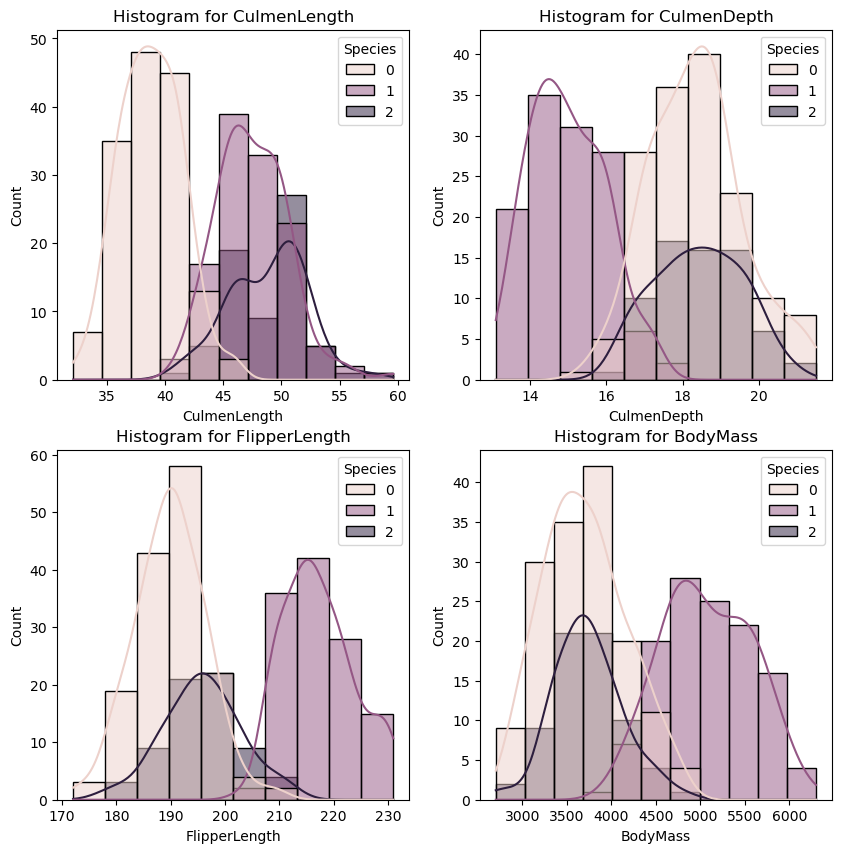

In [6]:
palette = [sns.cubehelix_palette()[i] for i in [0,3,5]]
features = df.columns[:4].to_list()
features

fig, axs = plt.subplots(2,2, figsize=(10, 10))
for f, ax in zip(features, axs.flat):
    sns.histplot(data=df, x=f, ax=ax, kde=True, hue='Species', palette=palette)
    ax.set_title(f"Histogram for {f}")
plt.show()


Below, the countplot displays the number of animals assigned to each class. Class 0 consists of 151 observations, class 1 has 123, and class 2 has only 68 samples. The data is not balanced.

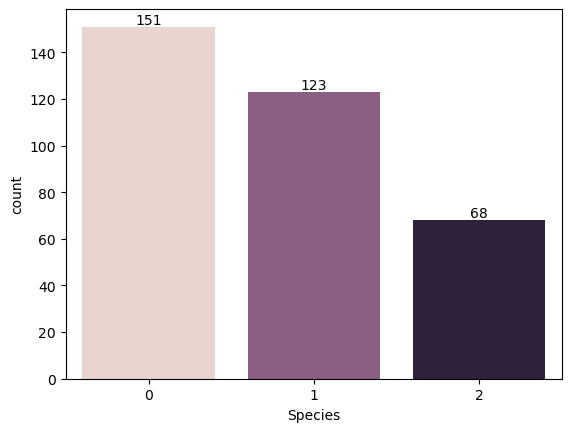

In [7]:
# Countplot of target variable
count = sns.countplot(data=df, x='Species', palette=palette)
plt.bar_label(count.containers[0])
plt.show()

Correlation analysis of the penguins' body measurements shows a strong positive correlation between flipper length and body mass. Culmen length also presents a positive relationship with these two features. Culmen depth, however, is negatively correlated with all variables.

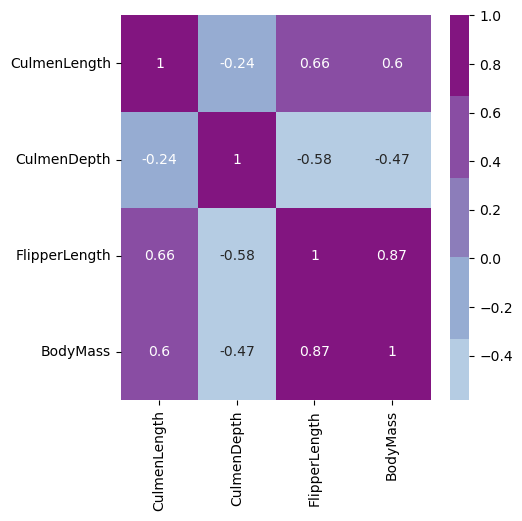

In [8]:
# Plot correlation heatmap
plt.figure(figsize=(5, 5))
ax = sns.heatmap(df[features].corr(),
                 xticklabels=df[features].corr().columns,
                 yticklabels=df[features].corr().columns,
                 cmap=sns.color_palette(palette='BuPu'),
                 center=0,
                 annot=True)


The multivariate data analysis presents the relationship between the studied features and the class assignments. The plot shows clear group clustering based on the features used.

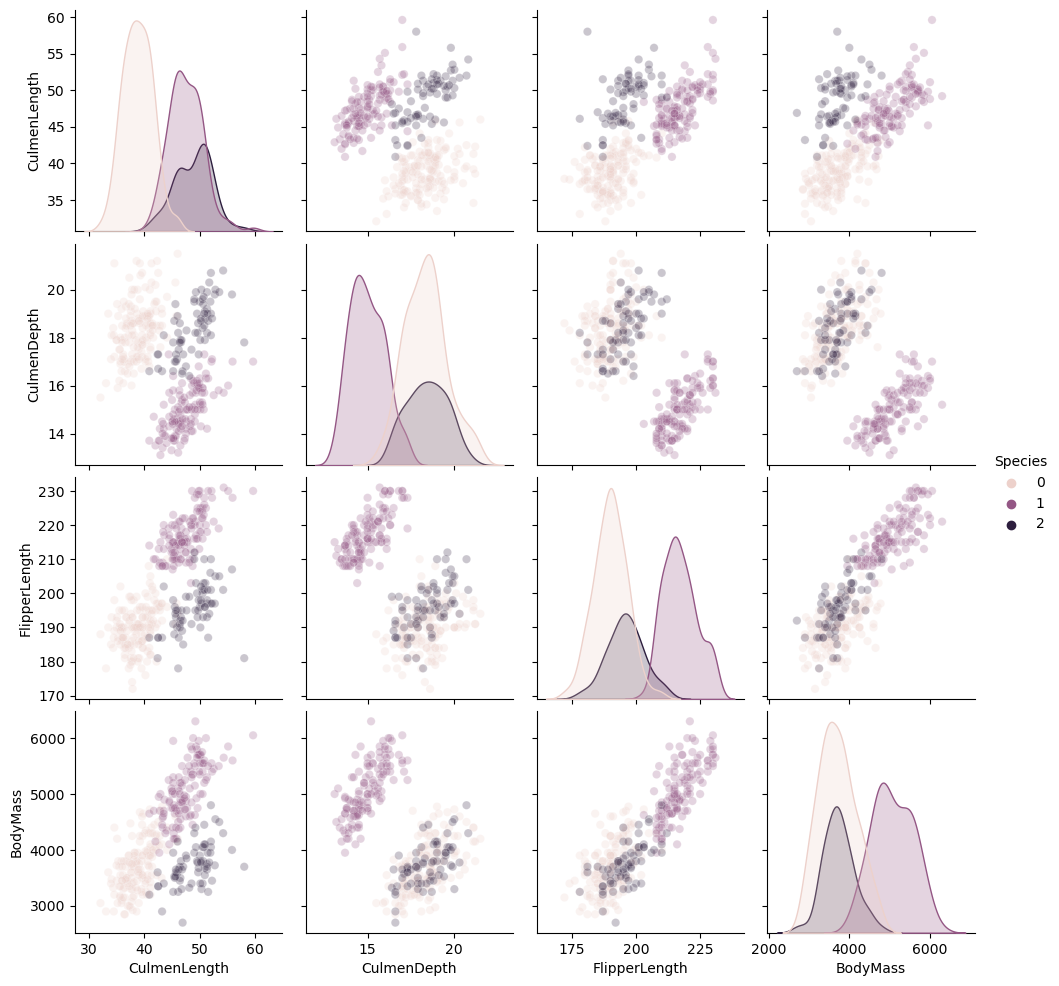

In [9]:
fig = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.25}, hue='Species', palette=palette)
plt.show()

## Training/Tasting split
The features and target variables have been split into training and testing sets, with testing data accounting for 30% of the total. The data have been scaled to perform classification using parametric models such as Logistic Regression, K-Nearest Neighbours, and SVM.


In [10]:
# Separate data into feature matrix and target vector
X=df.iloc[:,:4]
y=df['Species'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Training set:', X_train.shape, y_train.shape)
print('\nTesting set:', X_test.shape, y_test.shape)

# Standarisation of the data
scalar = StandardScaler().fit(X_train)
X_train_stand = scalar.transform(X_train)
X_test_stand = scalar.transform(X_test)


Training set: (239, 4) (239,)

Testing set: (103, 4) (103,)


## Logistic Regression

The first model used to classify the penguin species is Logistic Regression, incorporating regularization methods: Lasso (l1) and Ridge (l2), with adjustments to the C parameter.


Best hyperparameter: {'C': 100, 'penalty': 'l1'} 
Best score: 0.9964692218350756


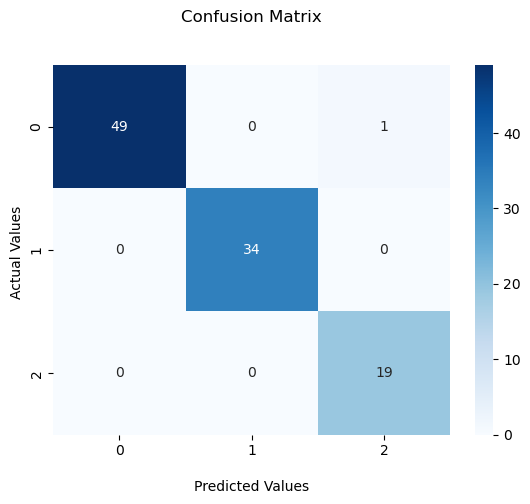

                 Model  F1_score  Accuracy
0  Logistic Regression  0.988086  0.990291


In [11]:
params_lr = {
    'penalty' : ['l1', 'l2'],
    'C' : [1e-3, 1e-2, 1e-1, 1, 10, 100]
    }

with ignore_warnings(category=(ConvergenceWarning)):

    logistic_regression = LogisticRegression(solver='liblinear', random_state=42)
    metrics = model_perform(logistic_regression, "Logistic Regression", params_lr, X_train_stand,y_train,X_test_stand,y_test)
    print(metrics)
    



The best performance for the Logistic Regression was observed with Lasso regularization and a C hyperparameter of 100 (indicating weak penalization). The model correctly classified nearly all testing data, with only one misclassification, and achieved an excellent F1 score of 0.988 for the unseen data.

## K Nearest Neighbors

The KNeighbors model was applied to the same scaled training data with varying numbers of neighbors.


Best hyperparameter: {'n_neighbors': 1} 
Best score: 0.9841998157787633


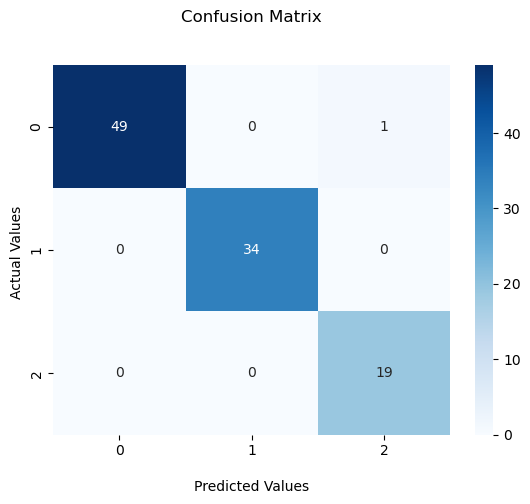

,Model,F1_score,Accuracy
0,Logistic Regression,0.988086,0.990291
0,KNeighbors,0.988086,0.990291


In [12]:
params_knn = {
    'n_neighbors': [i for i in range(1,9)]
}

kneighbors = KNeighborsClassifier()

model_perform(kneighbors, "KNeighbors", params_knn, X_train_stand,y_train,X_test_stand,y_test)



The best KNeighbors model grid search was observed for the n_neighbors of 1. Its performance was evaluated on the testing data, and the classifier performed exceptionally well with only one misclassification. The F1 score matched that of the Lasso Regression at 0.988.

## Decision Tree

The Decision Tree was used as the next model; however, the feature data were not scaled since it is a nonparametric model. A grid search was performed for different values of max_depth and min_samples_leaf to prevent the model from overfitting.


Best hyperparameter: {'max_depth': 2, 'min_samples_leaf': 3} 
Best score: 0.9608134748057727


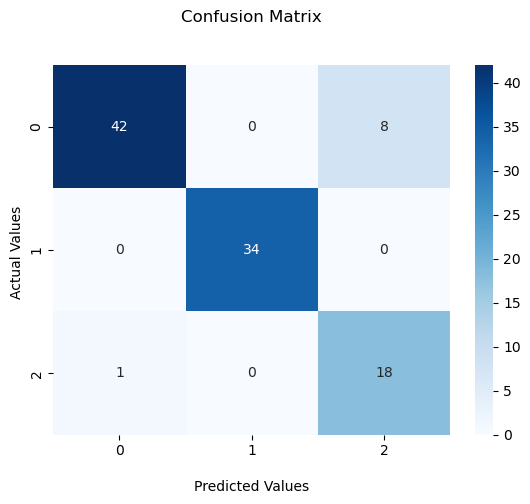

,Model,F1_score,Accuracy
0,Logistic Regression,0.988086,0.990291
0,KNeighbors,0.988086,0.990291
0,Decision Tree,0.901075,0.912621


In [13]:
params_dt = {
    'max_depth': [i for i in range(2,8)],
    'min_samples_leaf':[3,5,7,10]
}

model = DecisionTreeClassifier(random_state=42)
model_perform(model, "Decision Tree", params_dt, X_train,y_train,X_test,y_test)



Final results for the testing set achieved an F1 score of 0.901, with 9 samples misclassified between classes 0 and 2. This model performed significantly worse compared to Logistic Regression and KNeighbors. However, performance could be improved using ensemble methods such as Random Forest or AdaBoost based on the Decision Tree.

## SVM 

The next parametric model applied to the data is the Support Vector Machine (SVM). Using the GridSearch function, different kernel methods and various values for the C hyperparameter were tested to find the best performing model.


Best hyperparameter: {'C': 10, 'kernel': 'rbf'} 
Best score: 0.9948652118100128


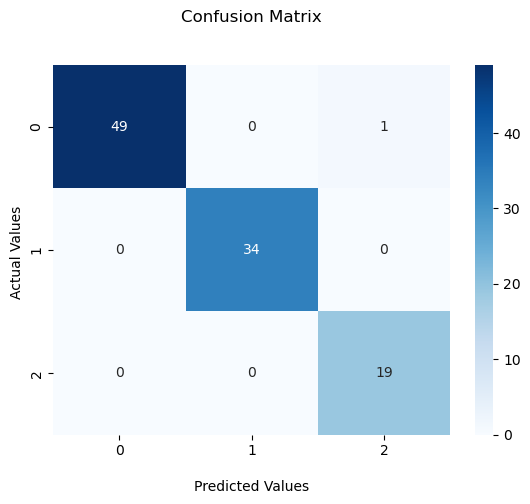

,Model,F1_score,Accuracy
0,Logistic Regression,0.988086,0.990291
0,KNeighbors,0.988086,0.990291
0,Decision Tree,0.901075,0.912621
0,SVC,0.988086,0.990291


In [14]:
param_svm = {
    'C':[1e-2, 1e-1, 1, 10, 100],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid']
}
model_svc = SVC(random_state=42)
model_perform(model_svc, "SVC", param_svm, X_train_stand, y_train, X_test_stand, y_test)


The final SVM model, using the RBF kernel and a C hyperparameter value of 10, achieved an F1 score of 0.988, with only one misclassified sample.

## Random Forest

The Random Forest model with three hyperparameters (n_estimators, max_depth, and min_samples_leaf) was trained using GridSearch on unscaled feature data.


Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100} 
Best score: 0.9692229600573631


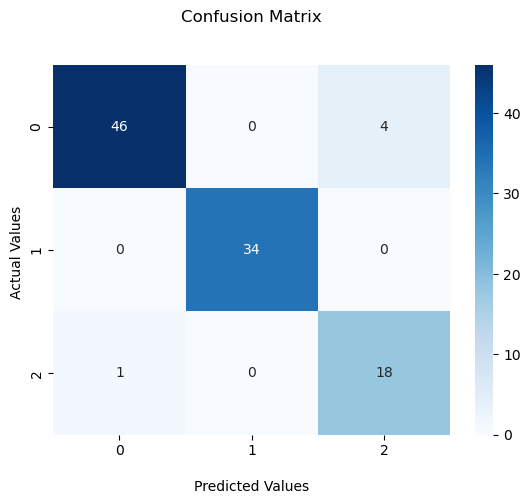

,Model,F1_score,Accuracy
0,Logistic Regression,0.988086,0.990291
0,KNeighbors,0.988086,0.990291
0,Decision Tree,0.901075,0.912621
0,SVC,0.988086,0.990291
0,Random Forest,0.942167,0.951456


In [15]:
params_rf = {
    'n_estimators':[50,100,200,500],
    'max_depth':[3,5,7,9,12],
    'min_samples_leaf':[3,5,8,10,15]
}

model_rf = RandomForestClassifier(random_state=42)
model_perform(model_rf, "Random Forest", params_rf, X_train,y_train,X_test,y_test)


The F1 score of 0.942 was achieved for the test dataset, representing an improvement over the performance of the single Decision Tree. However, it's evident that the parametric models are consistently achieving higher scores.

## AdaBoost

The AdaBoost ensemble, based on the best Decision Tree chosen previously, was trained below. Additionally, different values for n_estimators were implemented to enhance model performance."


Best hyperparameter: {'n_estimators': 50} 
Best score: 0.9689449368396736


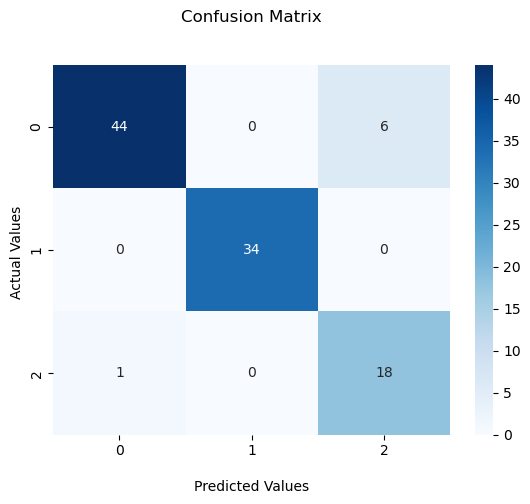

,Model,F1_score,Accuracy
0,Logistic Regression,0.988086,0.990291
0,KNeighbors,0.988086,0.990291
0,Decision Tree,0.901075,0.912621
0,SVC,0.988086,0.990291
0,Random Forest,0.942167,0.951456
0,AdaBoost,0.921175,0.932039


In [16]:
# AdaBoost using best decision tree
params_ada = {
    'n_estimators': [50,100, 200, 500]
}

model_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=42))
model_perform(model_ada, "AdaBoost", params_ada, X_train, y_train, X_test, y_test)

The final F1 score was 0.921, indicating improvement compared to the basic Decision Tree. However, overall, all of the parametric models (Logistic Regression, KNeighbors, and SVC) performed almost perfectly on the unseen data, achieving an accuracy of 0.990 and an F1 score of 0.988.